In [2]:
import os
import re
import pandas as pd
from googleapiclient.discovery import build
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import nltk

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Function to fetch YouTube comments
def fetch_youtube_comments(video_id, api_key, max_comments=10000):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
        )
        response = request.execute()
        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments[:max_comments]

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(tokens)

# Function to analyze sentiment using VADER
def analyze_vader_sentiment(comment):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(comment)
    if scores['compound'] > 0:
        return 'Positive'
    elif scores['compound'] < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Function to analyze sentiment using Hugging Face
def analyze_huggingface_sentiment_with_neutral(comment, huggingface_pipeline, neutral_threshold=0.5):
    tokens = huggingface_pipeline.tokenizer.tokenize(comment)
    max_length = huggingface_pipeline.tokenizer.model_max_length  # Typically 512
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in chunks:
        chunk_text = huggingface_pipeline.tokenizer.convert_tokens_to_string(chunk)
        result = huggingface_pipeline(chunk_text)[0]  # Result is a list with a dict for each label
        label = result['label']
        score = result['score']
        
        if score < neutral_threshold:
            sentiments.append('Neutral')
        else:
            sentiments.append(label)
    
    # Majority voting or averaging to handle multiple chunks
    positive_count = sentiments.count('POSITIVE')
    negative_count = sentiments.count('NEGATIVE')
    neutral_count = sentiments.count('Neutral')
    
    if neutral_count >= max(positive_count, negative_count):
        return 'Neutral'
    return 'POSITIVE' if positive_count > negative_count else 'NEGATIVE'


# Main function
def main():
    # Replace with your YouTube API key and video ID
    api_key = "API_KEY"  
    video_id = "VIDEO_ID"                                              #https://youtu.be/NsfMPTiIuvY?si=R3g-OTyftSABbqfo
                                                                       #https://youtu.be/oYj-PkAKLbA?si=xTfF6r0lc51zJZBC

    print("Fetching comments...")
    comments = fetch_youtube_comments(video_id, api_key)

    print("Preprocessing comments...")
    comments_cleaned = [preprocess_text(comment) for comment in comments]

    print("Initializing sentiment analysis models...")
    huggingface_pipeline_model = pipeline("sentiment-analysis")
    
    print("Analyzing sentiment with VADER...")
    vader_results = [analyze_vader_sentiment(comment) for comment in comments_cleaned]

    print("Analyzing sentiment with Hugging Face...")
    huggingface_results = [
        analyze_huggingface_sentiment_with_neutral(comment, huggingface_pipeline_model) for comment in comments_cleaned
    ]

    print("Saving results to CSV...")
    df = pd.DataFrame({
        'Original Comment': comments,
        'Cleaned Comment': comments_cleaned,
        'VADER Sentiment': vader_results,
        'Hugging Face Sentiment': huggingface_results
    })
    output_file = "savukku.csv"
    df.to_csv(output_file, index=False)
    print(f"Analysis saved to {output_file}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fetching comments...
Preprocessing comments...


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Initializing sentiment analysis models...


Device set to use cpu


Analyzing sentiment with VADER...
Analyzing sentiment with Hugging Face...
Saving results to CSV...
Analysis saved to savukku.csv


C:\Users\PRIYA\AppData\Local\Temp\ipykernel_9436\1376415561.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vader_counts.index, y=vader_counts.values, ax=axes[0], palette="viridis")
C:\Users\PRIYA\AppData\Local\Temp\ipykernel_9436\1376415561.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=huggingface_counts.index, y=huggingface_counts.values, ax=axes[1], palette="coolwarm")


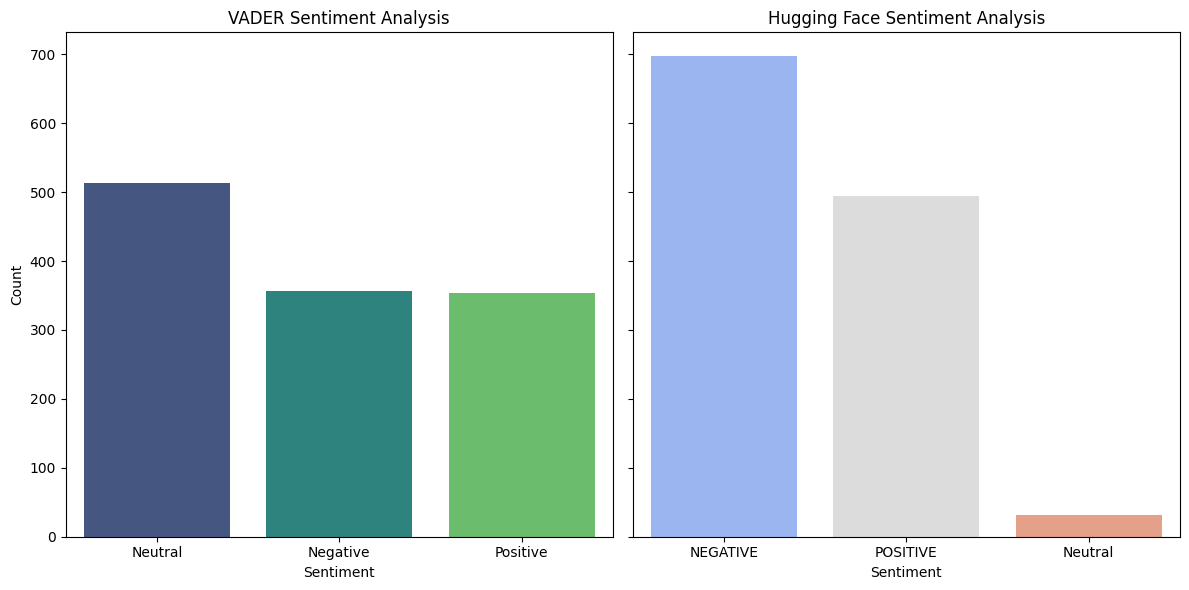

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize sentiment analysis results
def visualize_sentiment_results(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Count the sentiment categories
    vader_counts = df['VADER Sentiment'].value_counts()
    huggingface_counts = df['Hugging Face Sentiment'].value_counts()

    # Create subplots for VADER and Hugging Face
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # VADER Visualization
    sns.barplot(x=vader_counts.index, y=vader_counts.values, ax=axes[0], palette="viridis")
    axes[0].set_title("VADER Sentiment Analysis")
    axes[0].set_xlabel("Sentiment")
    axes[0].set_ylabel("Count")

    # Hugging Face Visualization
    sns.barplot(x=huggingface_counts.index, y=huggingface_counts.values, ax=axes[1], palette="coolwarm")
    axes[1].set_title("Hugging Face Sentiment Analysis")
    axes[1].set_xlabel("Sentiment")

    plt.tight_layout()
    plt.show()

# Main function for visualization
if __name__ == "__main__":
    # Specify the path to the CSV file
    csv_file = "vader&huggieee1.csv"
    visualize_sentiment_results(csv_file)
